<a href="https://colab.research.google.com/github/edakiziltas08/GitDeneme/blob/XMARKET/prepare_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
In this notebook, we explain all prerequisites for using our implementation.

Here are general steps you need to follow (this notebook covers the first two. train_all.ipynb covers the third):
1. Python. Make sure you have a python environment (conda or other) with libraries listed in requirements.txt
2. Data. The data preparation steps are provided in the DATA directory.
3. Commands. The rest of this notebook generates shell commands for starting the training process. We are running our code on a server with slurm for job management. You can change a little bit this notebook to adapt to your own environment. Providing GPU would make the running of these training jobs faster.

## Download XMarket Data

In [ ]:
import os
import urllib.request as urlreq

tgt_markets = ['ca', 'de', 'fr', 'in', 'jp', 'mx', 'uk', 'us']
tgt_cat = 'Electronics'

##########
### Download XMarket data for papers categories and markets
#########
fix_url = 'https://ciir.cs.umass.edu/downloads/XMarket/FULL/'
orig_data_dl = 'DATA2/orig_data'
proc_data_out = 'DATA2/proc_data'
if not os.path.exists(orig_data_dl):
    os.makedirs(orig_data_dl)
if not os.path.exists(proc_data_out):
    os.makedirs(proc_data_out)

for tgt_market in tgt_markets:
    cur_url = f'{fix_url}{tgt_market}/{tgt_cat}/ratings_{tgt_market}_{tgt_cat}.txt.gz'
    urlreq.urlretrieve(cur_url, f'{orig_data_dl}/ratings_{tgt_market}_{tgt_cat}.txt.gz')
    print(f'Done: {cur_url}')

Done: https://ciir.cs.umass.edu/downloads/XMarket/FULL/ca/Electronics/ratings_ca_Electronics.txt.gz
Done: https://ciir.cs.umass.edu/downloads/XMarket/FULL/de/Electronics/ratings_de_Electronics.txt.gz
Done: https://ciir.cs.umass.edu/downloads/XMarket/FULL/fr/Electronics/ratings_fr_Electronics.txt.gz
Done: https://ciir.cs.umass.edu/downloads/XMarket/FULL/in/Electronics/ratings_in_Electronics.txt.gz
Done: https://ciir.cs.umass.edu/downloads/XMarket/FULL/jp/Electronics/ratings_jp_Electronics.txt.gz
Done: https://ciir.cs.umass.edu/downloads/XMarket/FULL/mx/Electronics/ratings_mx_Electronics.txt.gz
Done: https://ciir.cs.umass.edu/downloads/XMarket/FULL/uk/Electronics/ratings_uk_Electronics.txt.gz
Done: https://ciir.cs.umass.edu/downloads/XMarket/FULL/us/Electronics/ratings_us_Electronics.txt.gz


## Process and Filter

In [ ]:
# set thr for K-core data cleaning. We use 5core, +1 valid and +1 test-> so at this point we filter 7core
user_thr = 7
item_thr = 7

# one can iterate a few times, we only perform one time filter
def get_kcore(ratings_all, user_thr, item_thr, repeat=1):
    for i in range(repeat):
        ratings_all.reset_index(drop=True, inplace=True)
        ratings_all = ratings_all.loc[ratings_all.groupby("itemId").filter(lambda x: len(x) >= item_thr).index]
        ratings_all.reset_index(drop=True, inplace=True)
        ratings_all = ratings_all.loc[ratings_all.groupby("userId").filter(lambda x: len(x) >= user_thr).index]
        ratings_all.reset_index(drop=True, inplace=True)
    return ratings_all

def rating_stats(ratings_all):
    n_rating = ratings_all.shape[0]
    n_user = len(set(ratings_all['userId'].unique()))
    n_item = len(set(ratings_all['itemId'].unique()))

    if (n_user*n_item)!=0:
        density = round((n_rating/(n_user*n_item) )*100, 5)
    else:
        density = 0

    return { '#users': n_user,
        '#items': n_item,
        '#rates': n_rating,
        'dens\%': density,
        }

In [ ]:
##########
### load and clean us market as the M0
#########
import pandas as pd

tgt_market = 'us'
us_ratings_file = f'{orig_data_dl}/ratings_{tgt_market}_{tgt_cat}.txt.gz'

us_df = pd.read_csv(us_ratings_file, compression='gzip', header=None, sep=' ', names=["userId", "itemId", "rate", "date"] )
us_df_7core = get_kcore(us_df, user_thr=user_thr, item_thr=item_thr)

us_user_thr = 10
us_item_thr = 25
us_df_10core = get_kcore(us_df, user_thr=us_user_thr, item_thr=us_item_thr)

# write us data
us_df_7core.to_csv(f'{proc_data_out}/{tgt_market}_5core.txt', index=False, sep=' ')
us_df_10core.to_csv(f'{proc_data_out}/{tgt_market}_10core.txt', index=False, sep=' ')

print('US Market data stats:')
print(rating_stats(us_df))
print(rating_stats(us_df_7core))
print(rating_stats(us_df_10core))

##########
### load and clean target markets
#########
us_items_set = set(us_df_10core['itemId'].unique())

for tgt_market in tgt_markets:
    if tgt_market=='us':
        continue
    #read market ratings
    cur_ratings_file = f'{orig_data_dl}/ratings_{tgt_market}_{tgt_cat}.txt.gz'
    cur_df = pd.read_csv(cur_ratings_file, compression='gzip', header=None, sep=' ', names=["userId", "itemId", "rate", "date"] )

    # item exist for us
    cur_df = cur_df.loc[cur_df['itemId'].isin( us_items_set )]
    cur_df_7core = get_kcore(cur_df, user_thr=user_thr, item_thr=item_thr)
    cur_df_7core.to_csv(f'{proc_data_out}/{tgt_market}_5core.txt', index=False, sep=' ')
    print(f'\n-- {tgt_market} stats: ')
    print(rating_stats(cur_df_7core))

US Market data stats:
{'#users': 2784128, '#items': 35943, '#rates': 4169476, 'dens\\%': 0.00417}
{'#users': 35916, '#items': 31125, '#rates': 364339, 'dens\\%': 0.03259}
{'#users': 12490, '#items': 24528, '#rates': 178811, 'dens\\%': 0.05837}

-- ca stats: 
{'#users': 5675, '#items': 5772, '#rates': 55045, 'dens\\%': 0.16805}

-- de stats: 
{'#users': 2373, '#items': 2210, '#rates': 22247, 'dens\\%': 0.42421}

-- fr stats: 
{'#users': 2396, '#items': 1911, '#rates': 22905, 'dens\\%': 0.50025}

-- in stats: 
{'#users': 239, '#items': 470, '#rates': 2015, 'dens\\%': 1.79382}

-- jp stats: 
{'#users': 487, '#items': 955, '#rates': 4485, 'dens\\%': 0.96434}

-- mx stats: 
{'#users': 1878, '#items': 1645, '#rates': 17095, 'dens\\%': 0.55336}

-- uk stats: 
{'#users': 4847, '#items': 3302, '#rates': 44515, 'dens\\%': 0.27814}


In [ ]:
import os
os.getcwd()
!ls

DATA2  sample_data


In [ ]:

import matplotlib.pyplot as plt
import pickle



item_map = {}
user_map = {}
idi =0
idu =0
dic_data = {}

for tgt_market in tgt_markets:
  print(tgt_market)
  if tgt_market=='us':
    cur_ratings_file = f'DATA2/proc_data/{tgt_market}_10core.txt'
  else:
    cur_ratings_file = f'DATA2/proc_data/{tgt_market}_5core.txt'
  cur_df = pd.read_csv(cur_ratings_file, header=0, sep=' ', names=["userId", "itemId", "rate", "date"] )
  for row in cur_df.iterrows():
    user_id = row[1]['userId']
    item_id = row[1]['itemId']
    if user_id not in user_map:
      user_map[user_id] = idu
      idu += 1
    if item_id not in item_map:
      item_map[item_id] = idi
      idi += 1

for tgt_market in tgt_markets:
  if tgt_market=='us':
    cur_ratings_file = f'DATA2/proc_data/{tgt_market}_10core.txt'
  else:
    cur_ratings_file = f'DATA2/proc_data/{tgt_market}_5core.txt'
  dic_data[tgt_market] = pd.read_csv(cur_ratings_file, header=0, sep=' ', names=["userId", "itemId", "rate", "date"] )
  dic_data[tgt_market]['userId'] = dic_data[tgt_market]['userId'].map(user_map)
  dic_data[tgt_market]['itemId'] = dic_data[tgt_market]['itemId'].map(item_map)




with open('DATA2/dic_XMARKET.pkl', 'wb') as f:
    pickle.dump(dic_data, f)

with open('DATA2/item_map.pkl', 'wb') as f:
    pickle.dump(item_map, f)

with open('DATA2/user_map.pkl', 'wb') as f:
    pickle.dump(user_map, f)

concatenated_df = pd.concat(dic_data.values(), ignore_index=True)

concatenated_df.to_csv('DATA2/concatenated_df.txt', index=False, sep=' ')

print(concatenated_df.head())

print(rating_stats(concatenated_df))





ca
de
fr
in
jp
mx
uk
us
   userId  itemId  rate        date
0       0       0   5.0  2016-10-08
1       1       1   4.0  2015-12-27
2       2       2   5.0  2017-11-09
3       3       3   4.0  2018-08-30
4       4       4   3.0  2015-10-04
{'#users': 30362, '#items': 24528, '#rates': 347118, 'dens\\%': 0.04661}


In [ ]:
import os
os.getcwd()
!ls

DATA2  sample_data


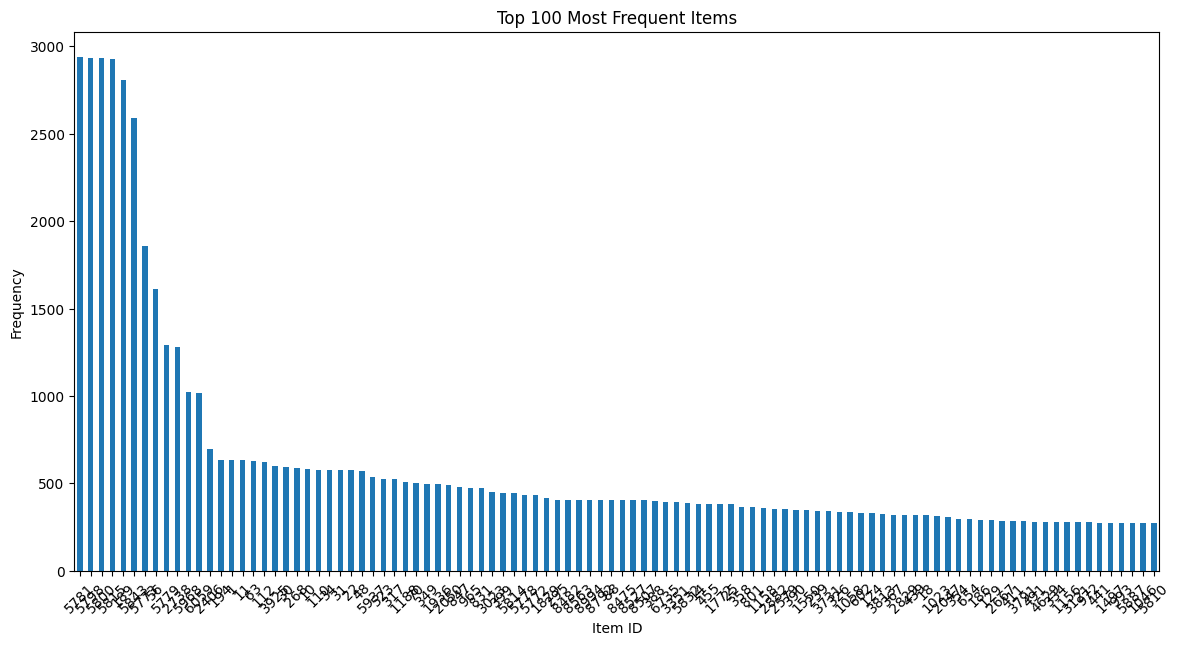

itemId
5781    2937
5798    2932
5800    2932
5815    2925
189     2810
        ... 
1497     275
993      273
5887     272
1046     272
5810     272
Name: count, Length: 100, dtype: int64


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
item_counts={}
top_100_items = {}

concatenated_df = pd.read_csv('DATA2/concatenated_df.txt', header=0, sep=' ', names=["userId", "itemId", "rate", "date"] )


item_counts["all"] = concatenated_df['itemId'].value_counts()

# Get top 100 items
top_100_items["all"]= item_counts["all"].head(100)

# Plot the frequency of the top 100 items
plt.figure(figsize=(14, 7))
top_100_items["all"].plot(kind='bar')
plt.title('Top 100 Most Frequent Items')
plt.xlabel('Item ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

print(top_100_items["all"])


ca


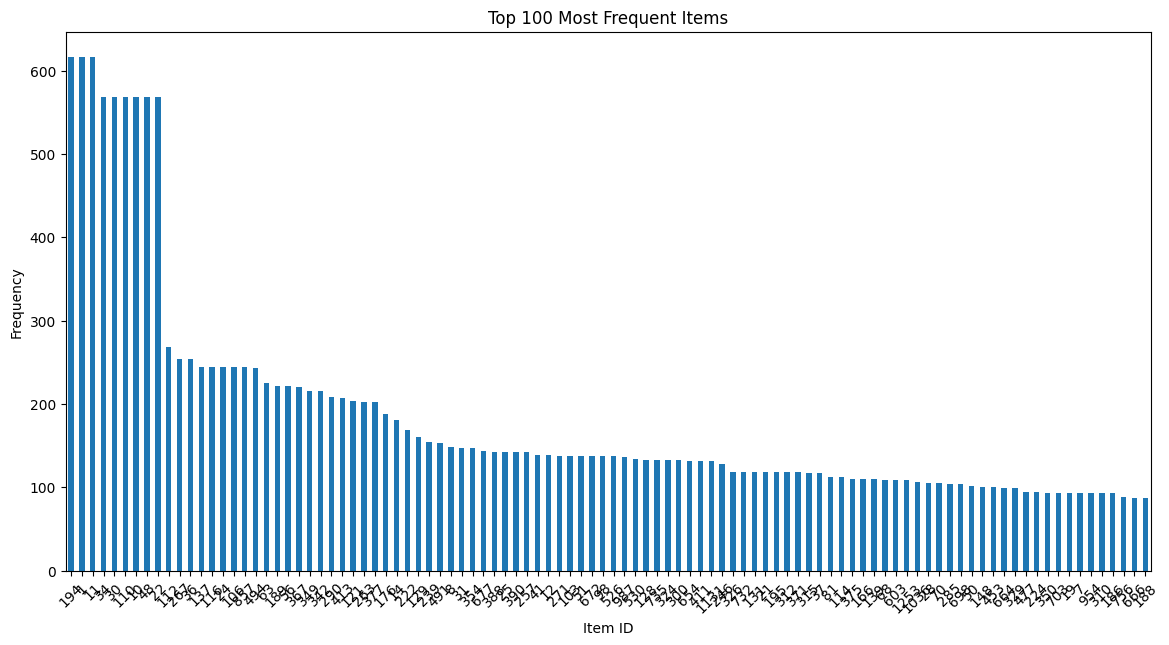

itemId
194    616
1      616
11     616
34     569
30     569
      ... 
310     93
186     93
756     88
666     87
188     87
Name: count, Length: 100, dtype: int64
de


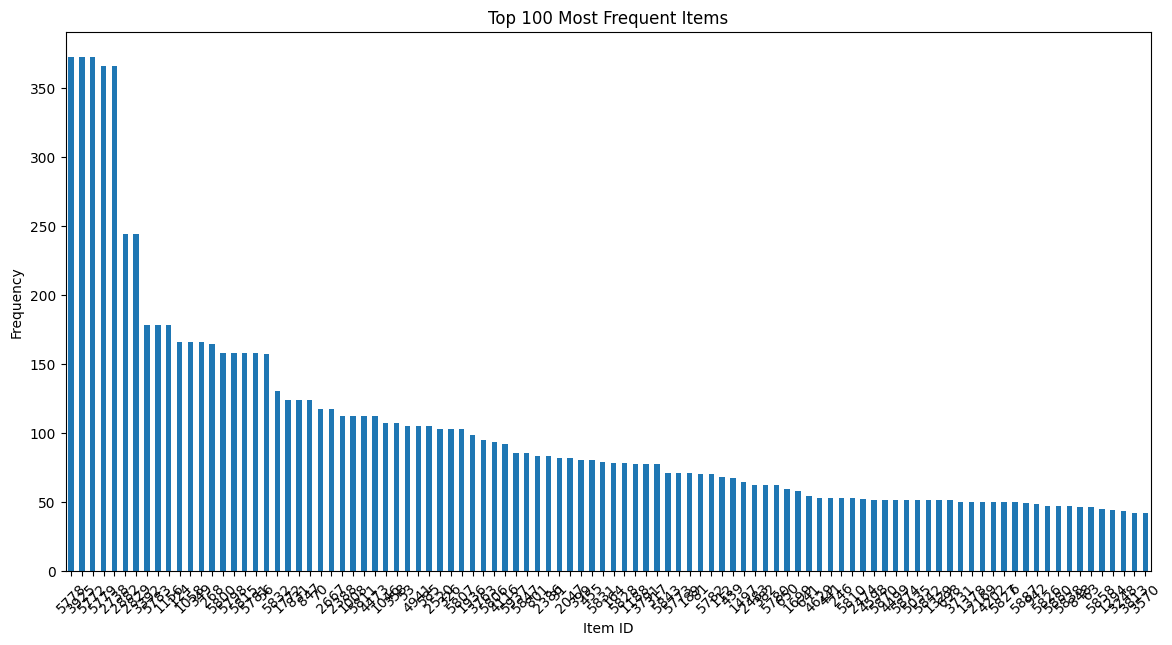

itemId
5778    372
3925    372
5772    372
5779    366
2738    366
       ... 
5858     45
1294     44
3248     43
3813     42
3570     42
Name: count, Length: 100, dtype: int64
fr


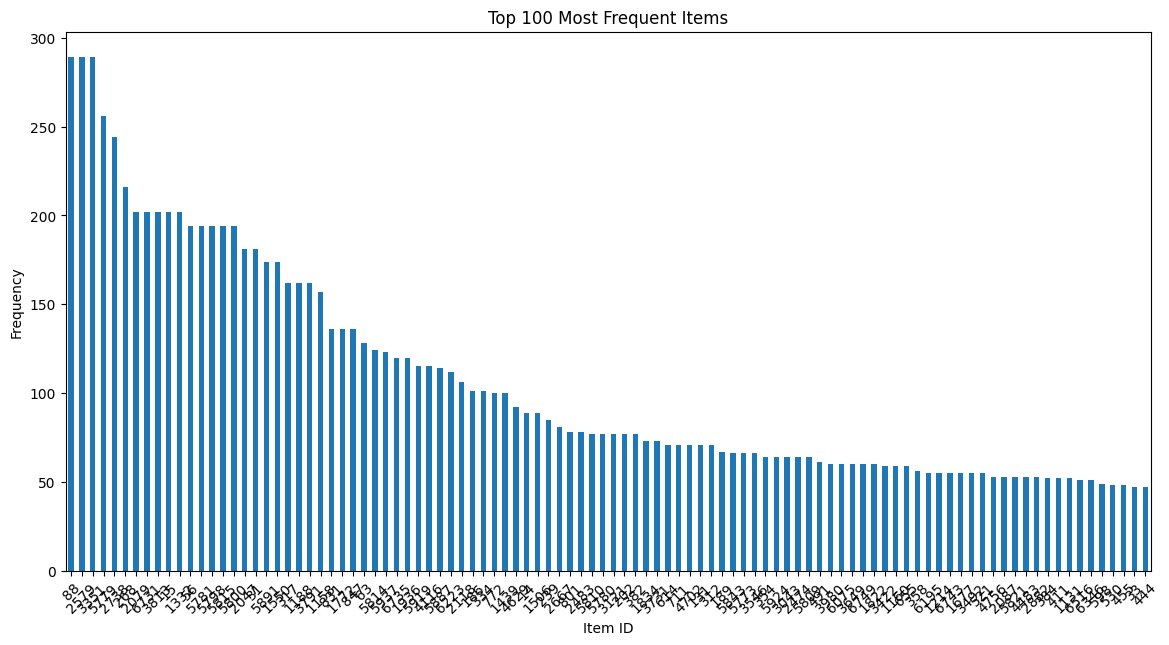

itemId
88      289
2579    289
3351    289
5779    256
2738    244
       ... 
598      49
530      48
455      48
33       47
444      47
Name: count, Length: 100, dtype: int64
in


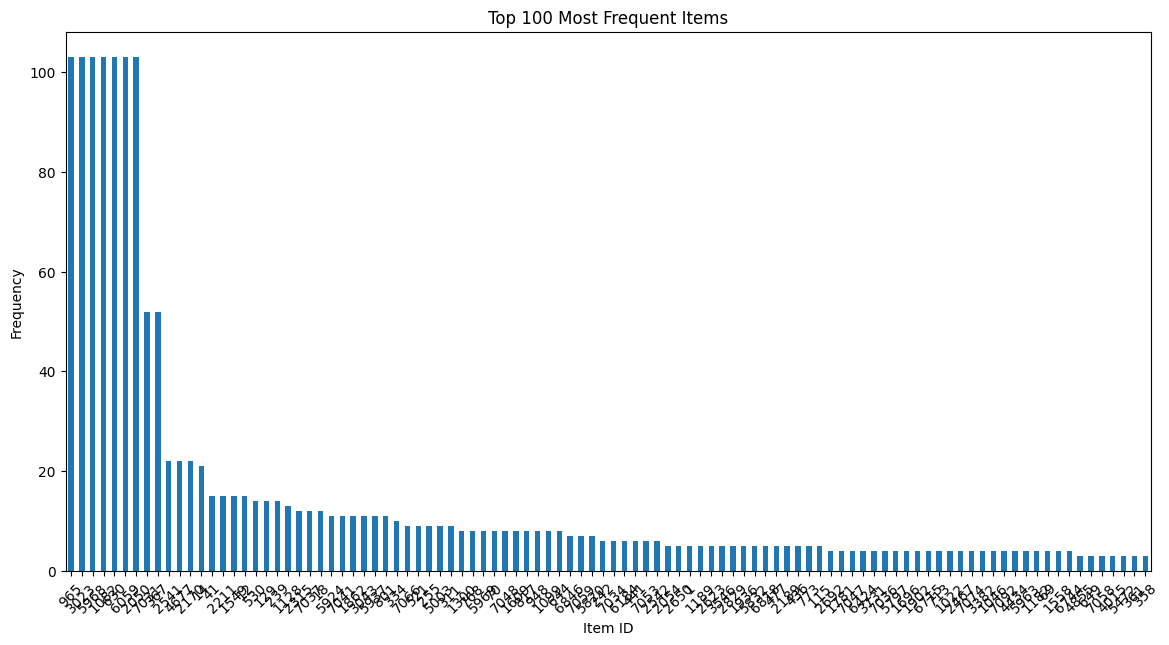

itemId
965     103
3023    103
5968    103
1082    103
630     103
       ... 
7058      3
4015      3
5472      3
361       3
358       3
Name: count, Length: 100, dtype: int64
jp


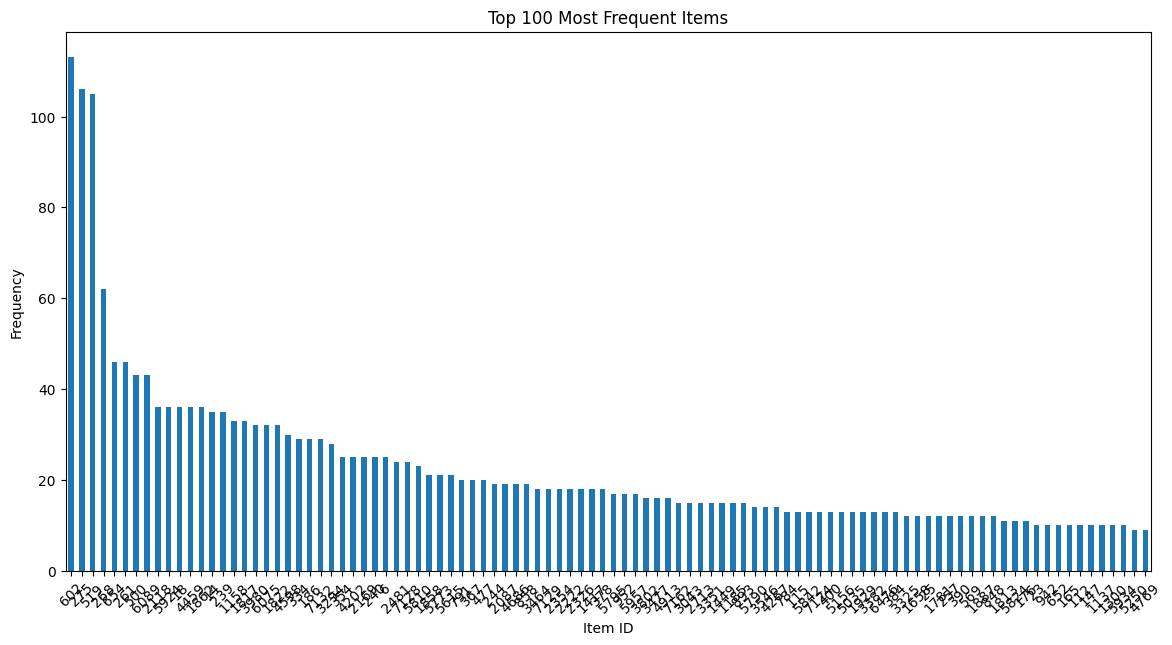

itemId
602     113
275     106
519     105
268      62
654      46
       ... 
1137     10
1300     10
5934     10
5250      9
4769      9
Name: count, Length: 100, dtype: int64
mx


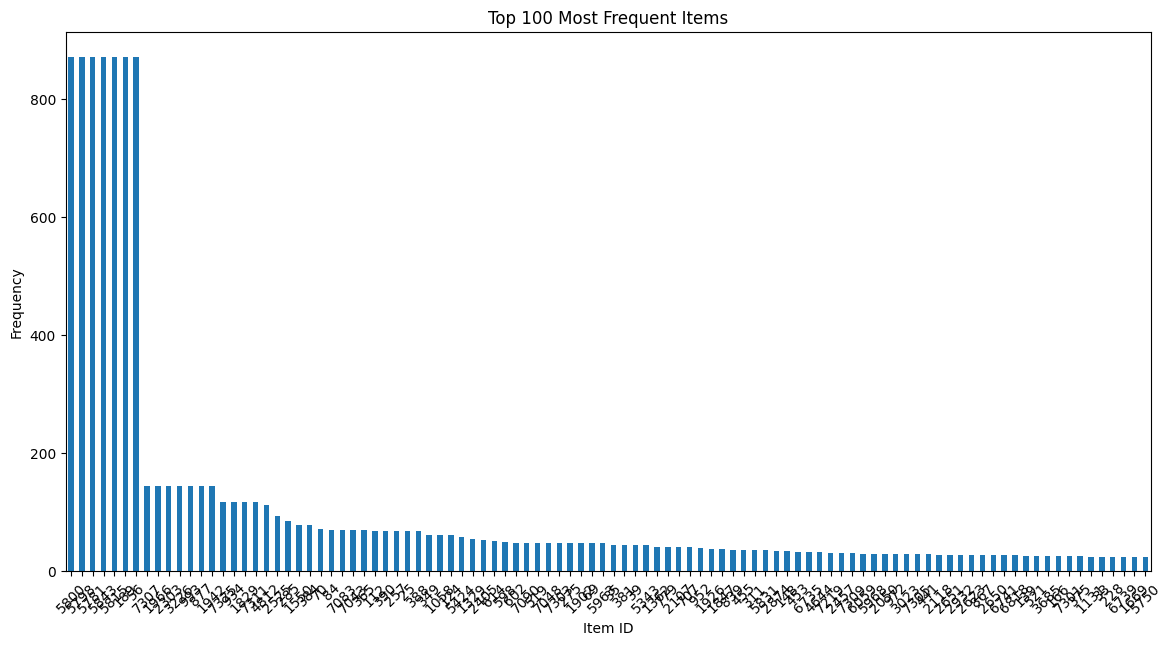

itemId
5800    871
5798    871
5781    871
5843    871
5815    871
       ... 
33       24
228      24
6739     23
1669     23
5750     23
Name: count, Length: 100, dtype: int64
uk


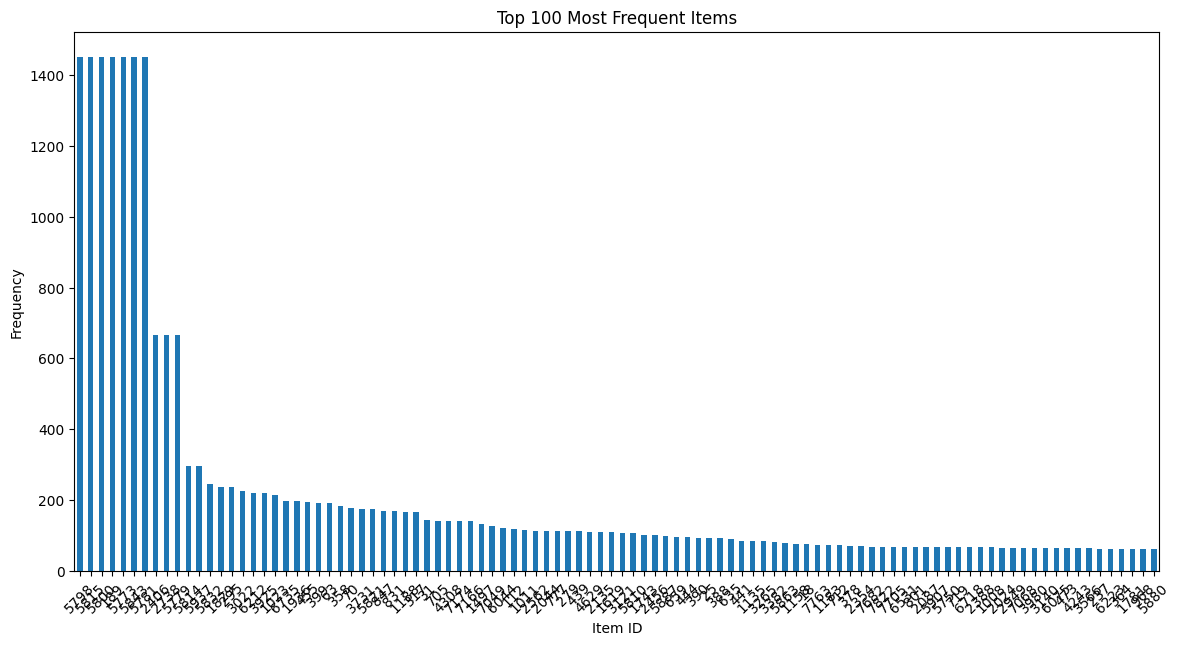

itemId
5798    1450
5815    1450
5800    1450
189     1450
5773    1450
        ... 
6223      61
364       61
1781      61
968       61
5880      60
Name: count, Length: 100, dtype: int64
us


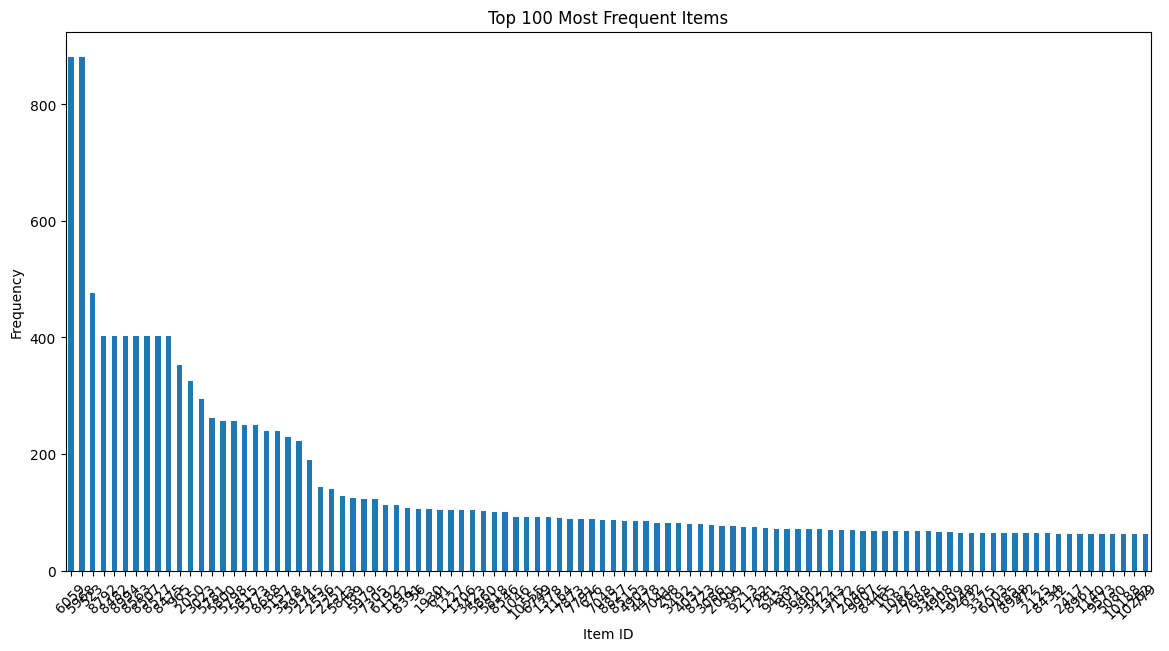

itemId
6059     881
5968     881
523      477
8792     403
8482     403
        ... 
9573      62
5080      62
10188     62
10262     62
779       62
Name: count, Length: 100, dtype: int64


In [6]:
tgt_markets = ['ca', 'de', 'fr', 'in', 'jp', 'mx', 'uk', 'us']
dic_data = {}
with open('DATA2/dic_XMARKET.pkl', 'rb') as f:
    dic_data = pickle.load(f)

for idx, tgt_market in enumerate (tgt_markets):
  print(tgt_market)
  item_counts[tgt_market]=dic_data[tgt_market]['itemId'].value_counts()
  top_100_items[tgt_market]= item_counts[tgt_market].head(100)
  # Plot the frequency of the top 100 items
  plt.figure(figsize=(14, 7))
  top_100_items[tgt_market].plot(kind='bar')
  plt.title('Top 100 Most Frequent Items')
  plt.xlabel('Item ID')
  plt.ylabel('Frequency')
  plt.xticks(rotation=45)
  plt.show()
  print(item_counts[tgt_market].head(100))

all
ca
de
fr
in
jp
mx
uk
us


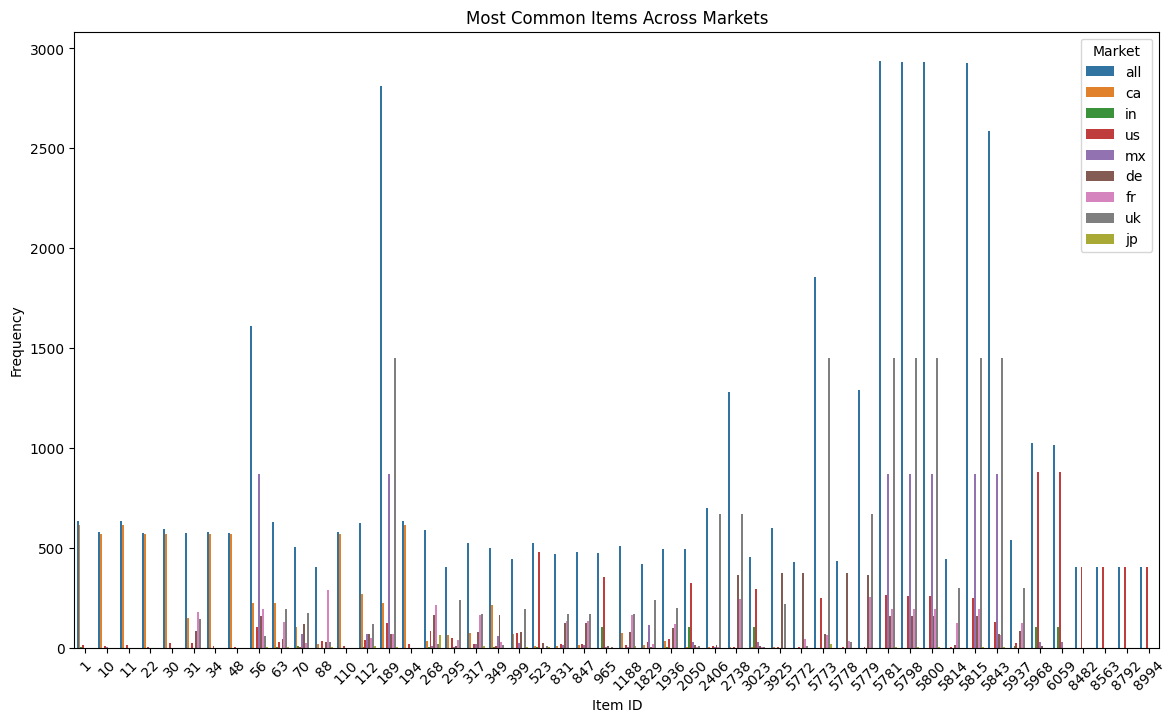

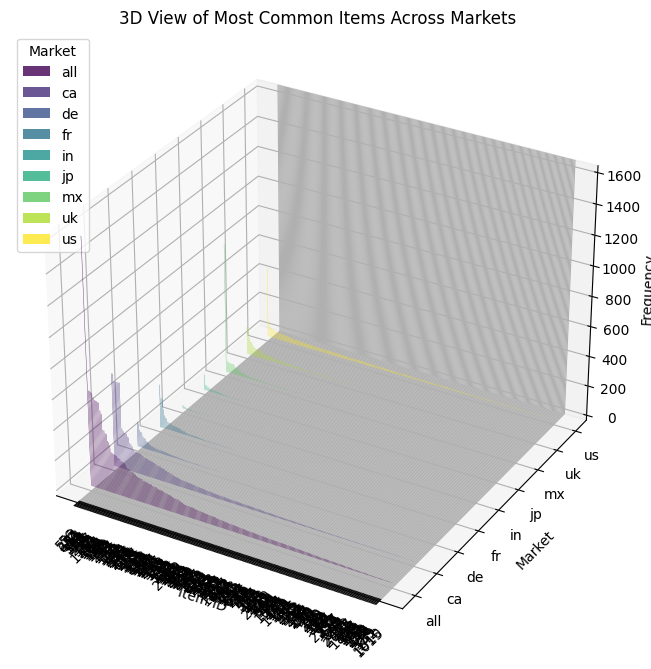

In [ ]:
import seaborn as sns
market_dfs = []
for market, data in item_counts.items():
    print(market)
    # if market=="all":
    #     continue
    df = data.reset_index()
    df.columns = ["itemId", "frequency"]  #
    df["market"] = market
    market_dfs.append(df)

combined_df = pd.concat(market_dfs, ignore_index=True)

top_items = combined_df.groupby("itemId")["frequency"].sum().nlargest(50).index
filtered_df = combined_df[combined_df["itemId"].isin(top_items)]

# Set up the plot
plt.figure(figsize=(14, 8))
sns.barplot(data=filtered_df, x="itemId", y="frequency", hue="market", dodge=True)

# Customize the plot
plt.title("Most Common Items Across Markets")
plt.xlabel("Item ID")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.legend(title="Market")
plt.show()



import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np




top_items2 = pd.concat(top_100_items, ignore_index=True)
# top_items2 = combined_df.groupby("itemId")["frequency"].sum().nlargest(50).index
filtered_df = combined_df[combined_df["itemId"].isin(top_items2)]
# Prepare data for 3D plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Set up color map for markets
markets = filtered_df["market"].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(markets)))

# Loop through each market and plot bars in 3D
for i, market in enumerate(markets):
    market_data = filtered_df[filtered_df["market"] == market]
    xs = np.arange(len(market_data["itemId"].unique()))
    ys = market_data["frequency"].values
    ax.bar(xs, ys, zs=i, zdir='y', color=colors[i], alpha=0.8, width=0.4, label=market)

# Set labels
ax.set_xlabel("Item ID")
ax.set_ylabel("Market")
ax.set_zlabel("Frequency")
ax.set_yticks(np.arange(len(markets)))
ax.set_yticklabels(markets)
ax.set_xticks(xs)
ax.set_xticklabels(market_data["itemId"].unique(), rotation=45)
ax.legend(title="Market", loc="upper left")

plt.title("3D View of Most Common Items Across Markets")
plt.show()

similarity of ca and de
0.12452862004412495
similarity of ca and fr
0.15505075259017373
similarity of ca and in
0.06832057384891647
similarity of ca and jp
0.141708340997934
similarity of ca and mx
0.11138513296399943
similarity of ca and uk
0.08656022310768036
similarity of ca and us
0.1442350625569857
similarity of de and fr
0.5179306119395516
similarity of de and in
0.05590303988906765
similarity of de and jp
0.14762563721803731
similarity of de and mx
0.29205830628098417
similarity of de and uk
0.43501788739473957
similarity of de and us
0.1880581005632892
similarity of fr and in
0.05844676389080258
similarity of fr and jp
0.23370984826801897
similarity of fr and mx
0.34120411425348435
similarity of fr and uk
0.4436662819962242
similarity of fr and us
0.1976428713465408
similarity of in and jp
0.07517581224697446
similarity of in and mx
0.030565150569878675
similarity of in and uk
0.024477718718279
similarity of in and us
0.40085020220376893
similarity of jp and mx
0.06756959691392

<Axes: >

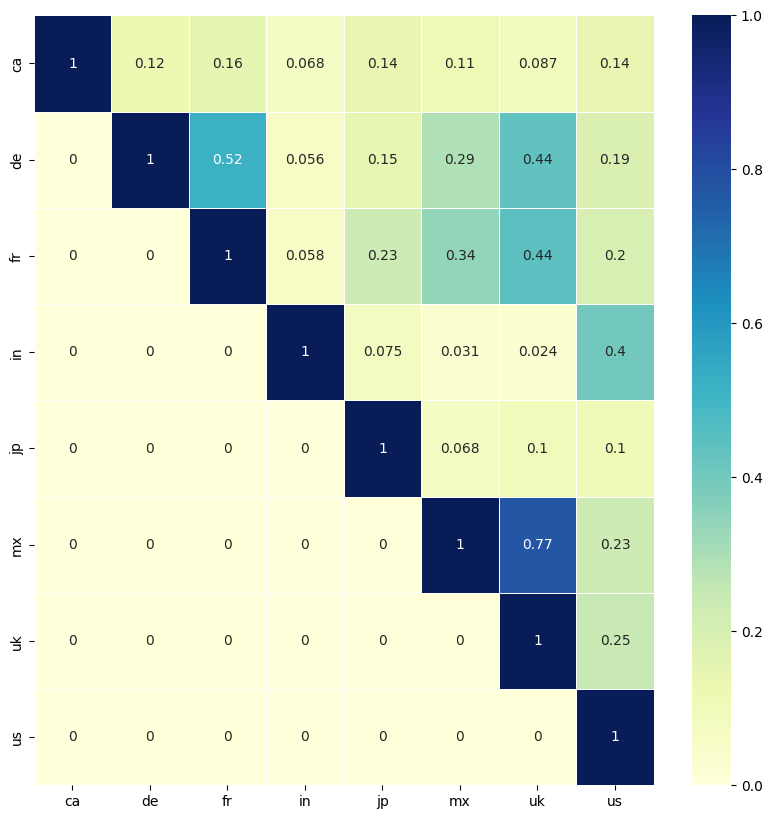

In [59]:
# with open ('DATA2/item_map.pkl', 'rb') as f:
#     item_map = pickle.load(f)


from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns


dfs = []
for market_name, series in item_counts.items():
    df = series.rename(market_name).reset_index()
    df = df.rename(columns={'index': 'itemId'})
    dfs.append(df)

combined_df = dfs[0]
for df in dfs[1:]:
    combined_df = pd.merge(combined_df, df, on='itemId', how='outer')

# Fill NaN values with 0
combined_df = combined_df.fillna(0)

tgt_markets2 = tgt_markets.copy()

sim =np.zeros((len(tgt_markets), len(tgt_markets)))

for idx, tgt_market in enumerate(tgt_markets):
  tgt_markets2.remove(tgt_market)
  for idx2, tgt_market2 in enumerate(tgt_markets2):
    print(f'similarity of {tgt_market} and {tgt_market2}')
    domains_matrix = np.stack([combined_df[tgt_market], combined_df[tgt_market2]])
    similarity_matrix = cosine_similarity(domains_matrix)
    sim[idx,idx+idx2+1] = similarity_matrix[0,1]
    print(similarity_matrix[0,1])
for idx, tgt_market in enumerate(tgt_markets):
  sim[idx,idx] = 1
sim = pd.DataFrame(sim, columns=tgt_markets, index=tgt_markets)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(sim, annot=True, cmap='YlGnBu', linewidths=.5, ax=ax)


# Optionally, add a total frequency column if you want the sum across all markets
# combined_df['total'] = combined_df.iloc[:, 1:].sum(axis=1)

# print(combined_df)


  # for i in range(len(item_map)):
  #   if i in dic_data[tgt_market]['itemId'].unique():
  #      item_cnts[tgt_market][i] = df(df["itemId"]==i)




# # Calculate cosine similarity between domains
# similarity_matrix = cosine_similarity(domains_matrix)

# print(similarity_matrix)


In [110]:
de= dic_data['de']
fr = dic_data['fr']


common_items = set(de['itemId'].unique()).intersection(set(fr['itemId'].unique()))


de_common = de[de['itemId'].isin(common_items)]
fr_common = fr[fr['itemId'].isin(common_items)]
item_de_r, item_fr_r = np.zeros(max(common_items)+1), np.zeros(max(common_items)+1)
item_de, item_fr = np.zeros(max(common_items)+1), np.zeros(max(common_items)+1)

for item in common_items:
  item_de[item] =de_common[de_common['itemId']==item]['itemId'].value_counts().iloc[0]
  item_fr[item] =fr_common[fr_common['itemId']==item]['itemId'].value_counts().iloc[0]
  item_de_r[item] = de_common[de_common['itemId']==item]['rate'].mean()
  item_fr_r[item] = fr_common[fr_common['itemId']==item]['rate'].mean()







In [111]:
item_cnt= {}
item_cnt['de'] = item_de
item_cnt['fr'] = item_fr

item_rate = {}
item_rate['de'] = item_de_r
item_rate['fr'] = item_fr_r

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
# colors = plt.cm.viridis(np.linspace(0, 1, len(markets)))
colors = ['red','orange']



# Concatenate all markets' data into a single DataFrame
# combined_df = pd.concat(market_dfs, ignore_index=True)

# plt.figure(figsize=(14, 8))
# sns.barplot(data=item_cnt, x="itemId", y="frequency", hue=['de','fr'], dodge=True)

# # Customize the plot
# plt.title("Most Common Items Across Markets")
# plt.xlabel("Item ID")
# plt.ylabel("Frequency")
# plt.xticks(rotation=45)
# plt.legend(title="Market")
# plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

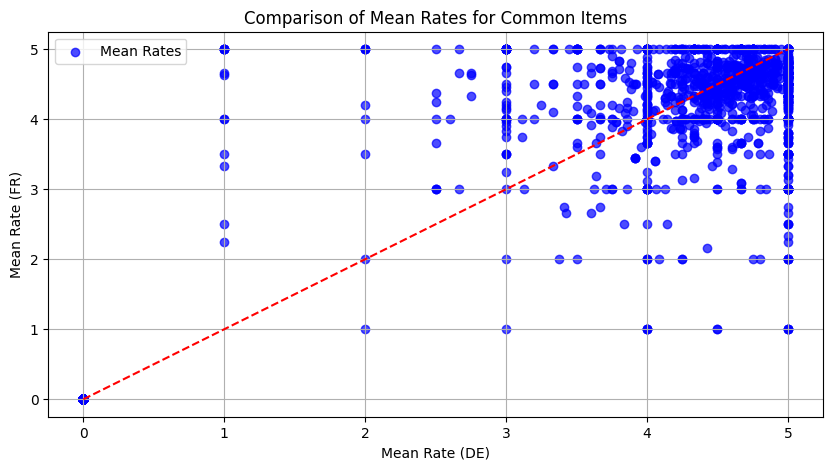

ValueError: The number of FixedLocator locations (6722), usually from a call to set_ticks, does not match the number of labels (1277).

Error in callback <function flush_figures at 0x7ddeb3681090> (for post_execute):


KeyboardInterrupt: 

In [133]:
import matplotlib.pyplot as plt

# Scatter Plot for Mean Rates
plt.figure(figsize=(10, 5))
plt.scatter(item_rate['de'], item_rate['fr'], alpha=0.7, color='blue', label='Mean Rates')
plt.plot([min(item_rate['de']), max(item_rate['de'])], [min(item_rate['de']), max(item_rate['de'])], color='red', linestyle='--')
plt.xlabel("Mean Rate (DE)")
plt.ylabel("Mean Rate (FR)")
plt.title("Comparison of Mean Rates for Common Items")
plt.legend()
plt.grid(True)
plt.show()

# Bar Plot for Counts


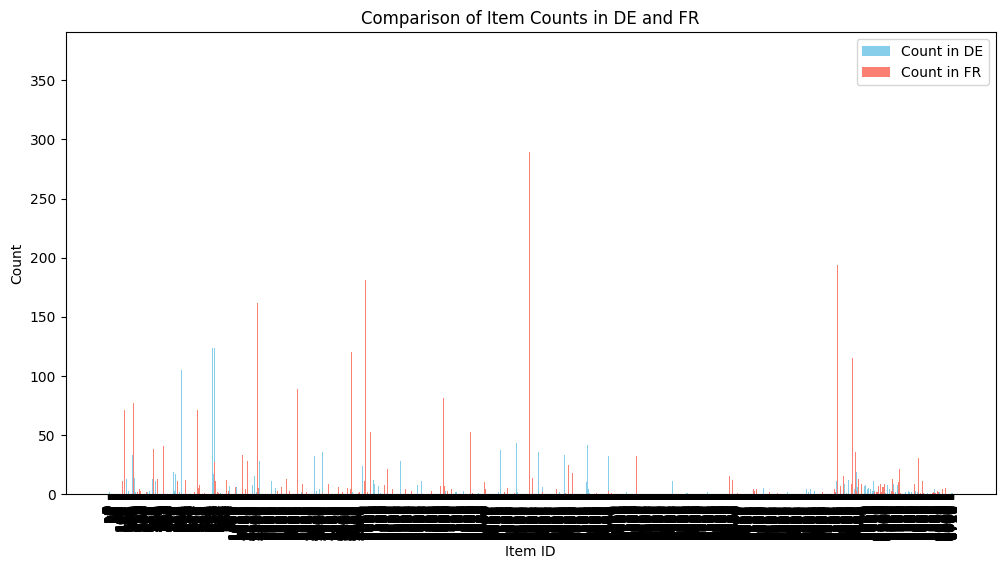

In [136]:
width = 0.7  # width of bars
x = range(len(item_cnt['de']))

plt.figure(figsize=(12, 6))
plt.bar(x, item_cnt['de'], width, label='Count in DE', color='skyblue')
plt.bar([p + width for p in x], item_cnt['fr'], width, label='Count in FR', color='salmon')
plt.xlabel("Item ID")
plt.ylabel("Count")
plt.title("Comparison of Item Counts in DE and FR")
plt.xticks([p + width/2 for p in x], range(max(common_items)+1), rotation=90)
plt.legend()
plt.show()

['de', 'fr']


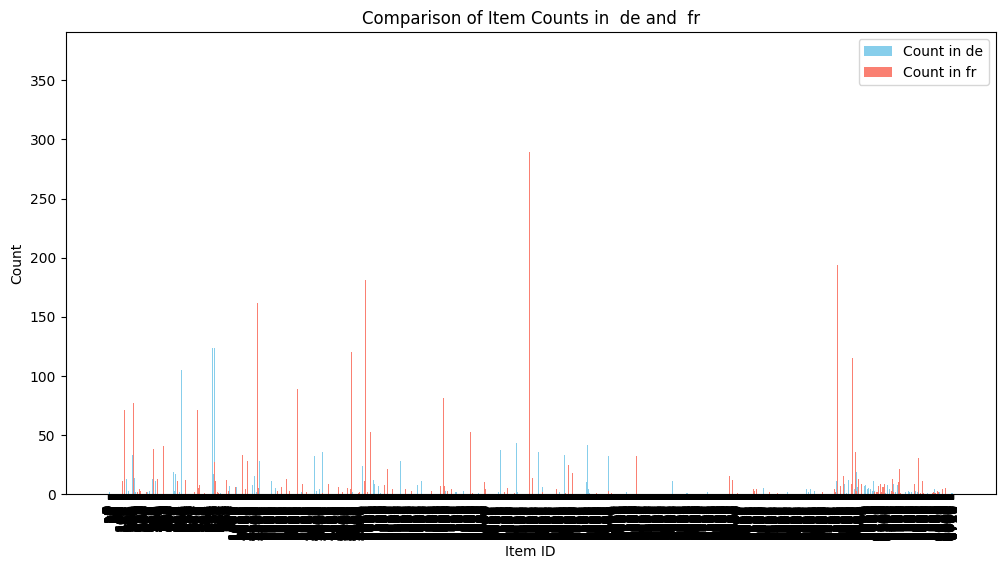

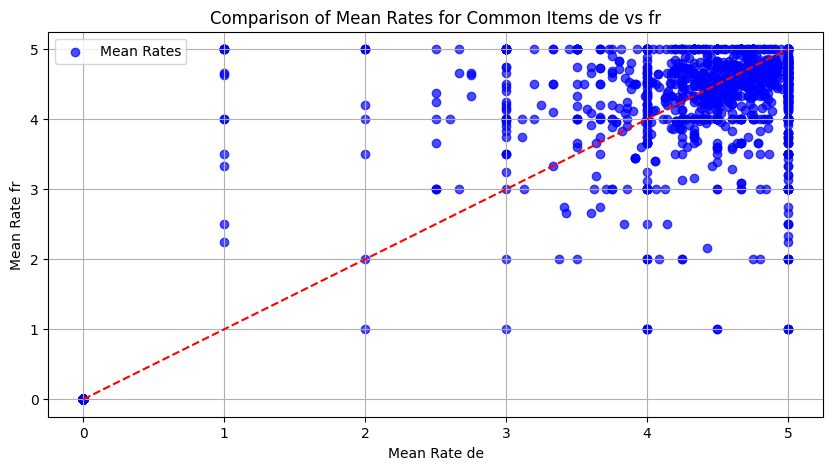

['de', 'uk']


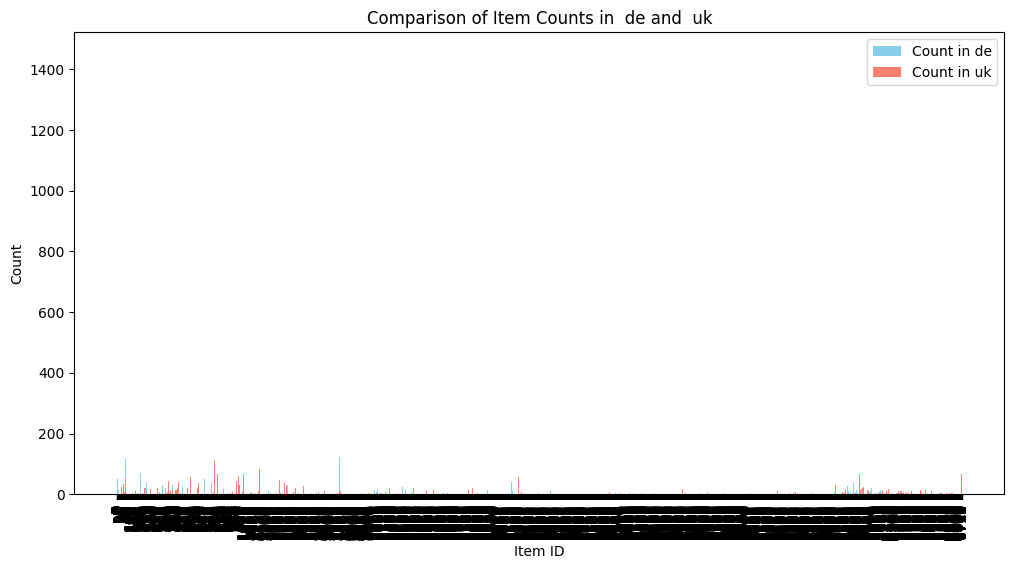

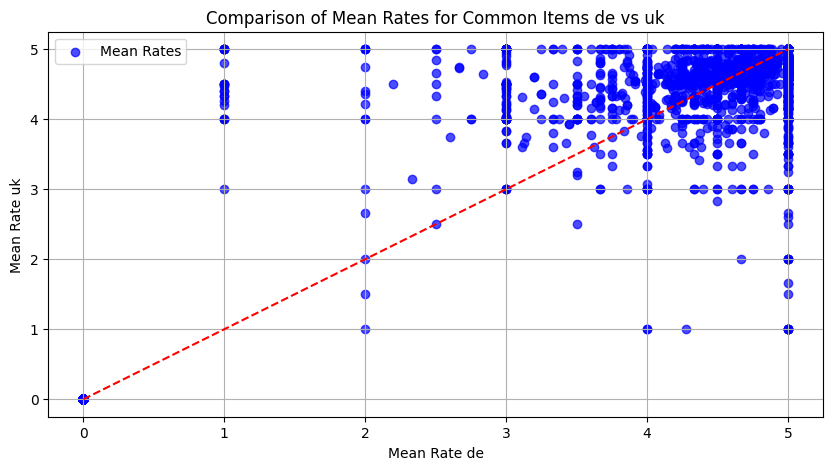

['fr', 'uk']


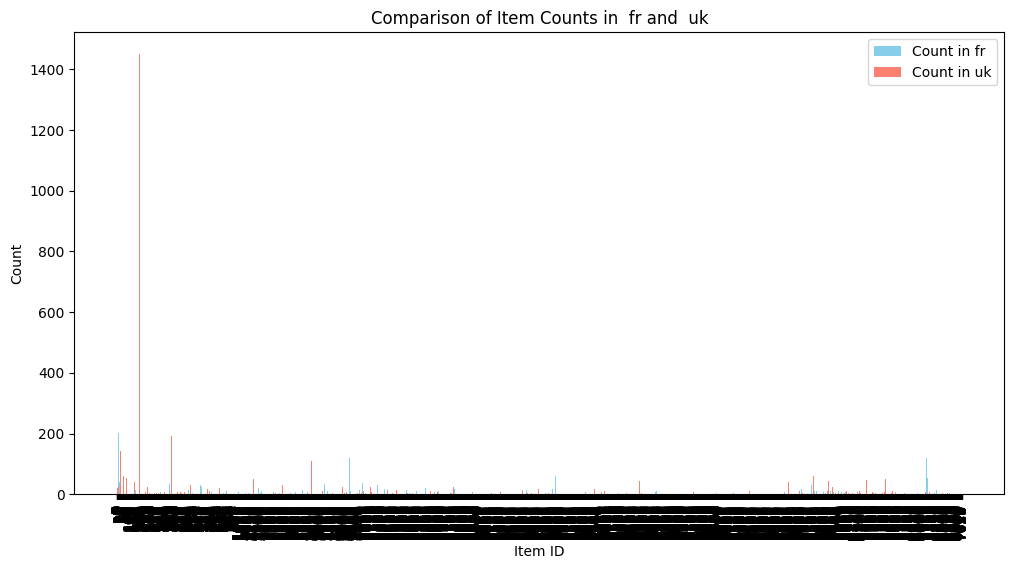

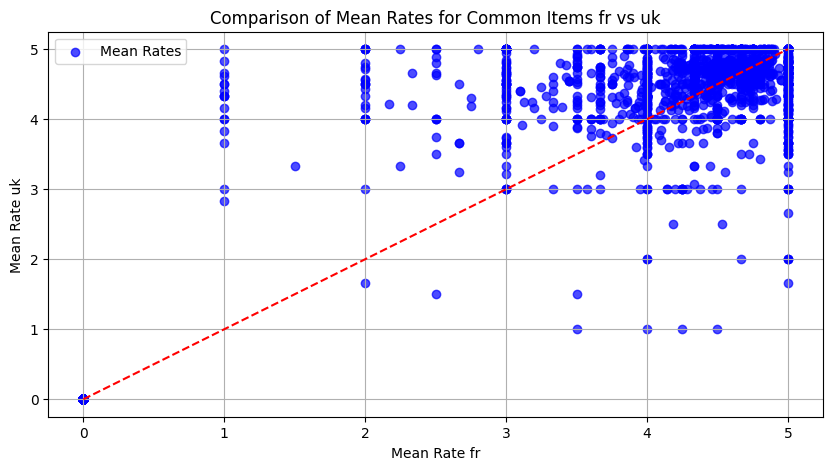

['in', 'us']


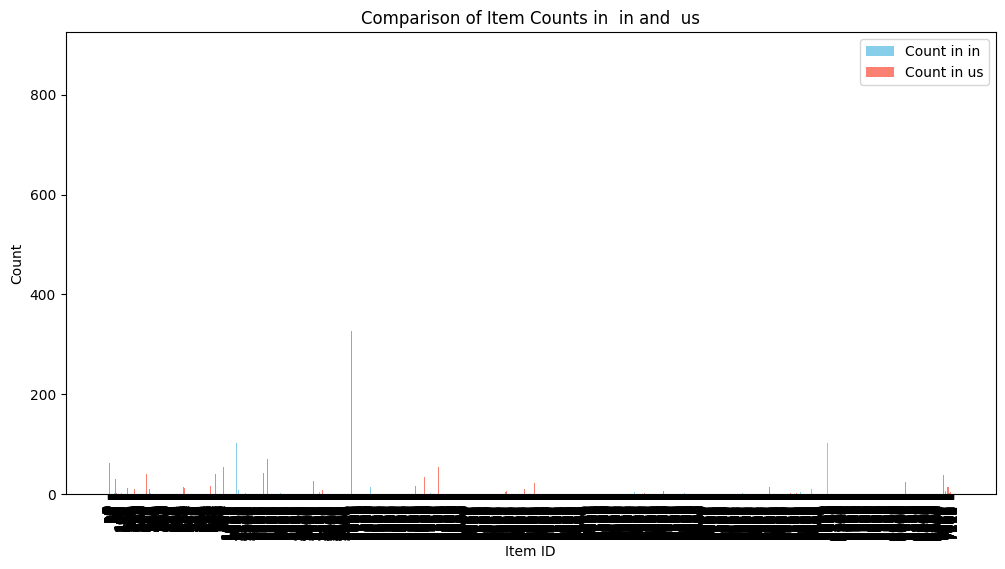

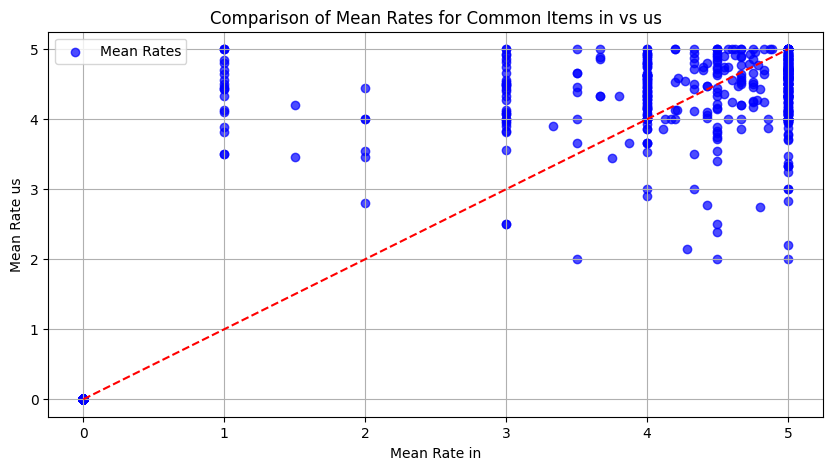

['mx', 'uk']


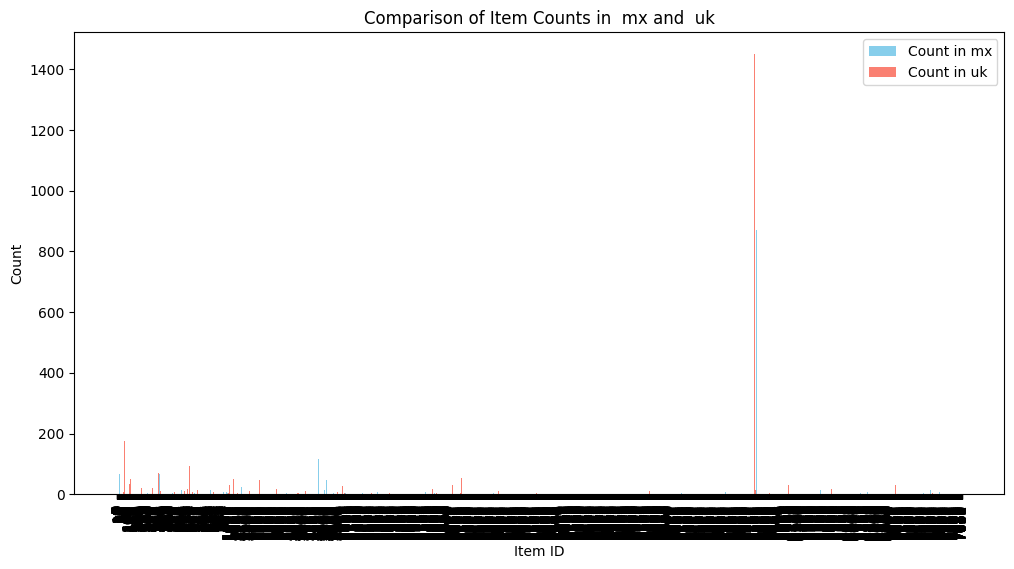

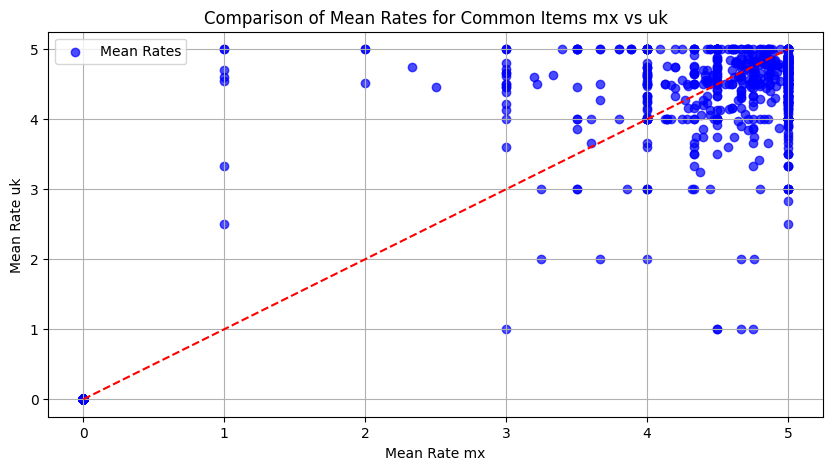

In [143]:
market_couples = [['de', 'fr'], ['de', 'uk'], ['fr', 'uk'], ['in', 'us'], ['mx', 'uk']]

xmin, xmax = 0, 300
ymin, ymax = 0, 300

for markets in market_couples:
  print(markets)
  de= dic_data[markets[0]]
  fr = dic_data[markets[1]]


  common_items = set(de['itemId'].unique()).intersection(set(fr['itemId'].unique()))


  de_common = de[de['itemId'].isin(common_items)]
  fr_common = fr[fr['itemId'].isin(common_items)]
  item_de_r, item_fr_r = np.zeros(max(common_items)+1), np.zeros(max(common_items)+1)
  item_de, item_fr = np.zeros(max(common_items)+1), np.zeros(max(common_items)+1)

  for item in common_items:
    item_de[item] =de_common[de_common['itemId']==item]['itemId'].value_counts().iloc[0]
    item_fr[item] =fr_common[fr_common['itemId']==item]['itemId'].value_counts().iloc[0]
    item_de_r[item] = de_common[de_common['itemId']==item]['rate'].mean()
    item_fr_r[item] = fr_common[fr_common['itemId']==item]['rate'].mean()

    item_cnt= {}
    item_cnt[markets[0]] = item_de
    item_cnt[markets[1]] = item_fr

    item_rate = {}
    item_rate[markets[0]] = item_de_r
    item_rate[markets[1]] = item_fr_r

  width = 0.7  # width of bars
  x = range(len(item_cnt[markets[0]]))

  plt.figure(figsize=(12, 6))
  plt.bar(x, item_cnt[markets[0]], width, label=f'Count in {markets[0]}', color='skyblue')
  plt.bar([p + width for p in x], item_cnt[markets[1]], width, label=f'Count in {markets[1]}', color='salmon')
  plt.xlabel("Item ID")
  plt.ylabel("Count")
  ax.set_xlim([xmin, xmax])
  ax.set_ylim([ymin, ymax])
  plt.title(f'Comparison of Item Counts in  {markets[0]} and  {markets[1]}')
  plt.xticks([p + width/2 for p in x], range(max(common_items)+1), rotation=90)
  plt.legend()
  plt.show()



  plt.figure(figsize=(10, 5))
  plt.scatter(item_rate[markets[0]], item_rate[markets[1]], alpha=0.7, color='blue', label='Mean Rates')
  plt.plot([min(item_rate[markets[0]]), max(item_rate[markets[0]])], [min(item_rate[markets[0]]), max(item_rate[markets[0]])], color='red', linestyle='--')
  plt.xlabel(f'Mean Rate {markets[0]}')
  plt.ylabel(f'Mean Rate {markets[1]}')
  plt.title(f'Comparison of Mean Rates for Common Items {markets[0]} vs {markets[1]}')
  plt.legend()
  plt.grid(True)
  plt.show()
